# Exercise: Conversion Rate
We have data about users who hit our site. We know whether they converted or not, as well as
some of their basic characteristics such as the country they’re in, the marketing channel that
brought them to the site, their age, whether they are repeat users, and the number of pages
visited during that session (as a proxy for site activity/time spent on the site).
The project is to:

1. Perform Exploratory Data Analysis and produce 2-3 plots that show either important
features or interesting patterns in the data. It is up to you what you want to highlight.
2. Build a model to predict conversion rate and critically evaluate it, explaining your choice
of model and performance metric.
3. Come up with recommendations for the product team and the marketing team to
improve conversion rate.


In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

## 1. Load data: 
<ol>
It has 6 attributes, 2 of them are categorical (country and source) and 4 of them are numerical.
</ol>

In [3]:
data = pd.read_csv('conversion_data.csv')
data.head()

,country,age,new_user,source,total_pages_visited,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0
2,US,28,1,Seo,4,0
3,China,39,1,Seo,5,0
4,US,30,1,Seo,6,0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316200 entries, 0 to 316199
Data columns (total 6 columns):
country                316200 non-null object
age                    316200 non-null int64
new_user               316200 non-null int64
source                 316200 non-null object
total_pages_visited    316200 non-null int64
converted              316200 non-null int64
dtypes: int64(4), object(2)
memory usage: 14.5+ MB


## 2. EDA
<ol>
    <li>
    scatter plot of numerical data with correlation and distribution
        </li>
       <li> 
    bar plot of catergorical data with distribution
    </li>
</ol>

CPU times: user 10.3 s, sys: 153 ms, total: 10.5 s
Wall time: 9.06 s


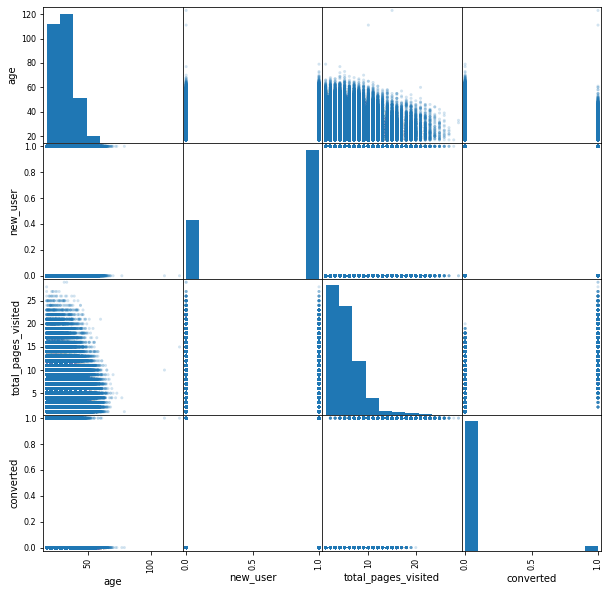

In [11]:
%%time
_ = pd.plotting.scatter_matrix(data, alpha=0.2, figsize=(10,10))

### EDA findings -1:
<ol>
    <li>
    'converted' rate is very low according to chart matrix[3][3]
    </li>
    <li>
    there seems a correlation between 'age' and 'total_pages_visited': matrix[0][2]
    </li>
    <li>
    we could see a logistic_regression trend between 'total_pages_visited' and 'converted': matrix[3][2]
    </li>
</ol>
    

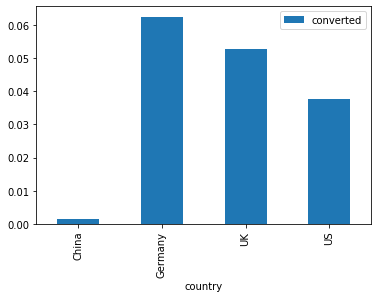

In [16]:
# average convert rate by country
data[['country','converted']].groupby('country').mean().plot(kind='bar')

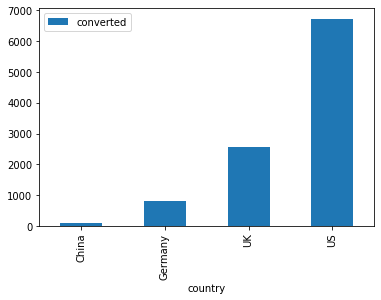

In [17]:
# total convert rate by country
data[['country','converted']].groupby('country').sum().plot(kind='bar')

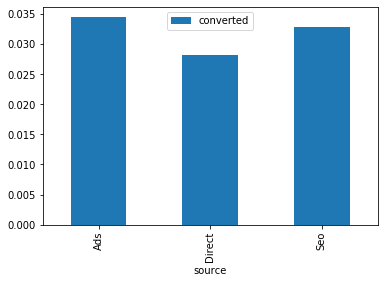

In [21]:
data[['source','converted']].groupby('source').mean().plot(kind='bar')

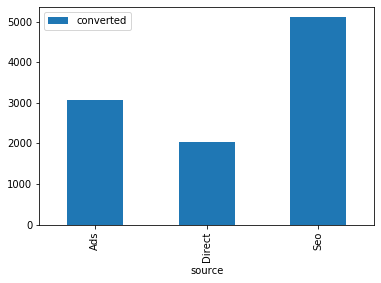

In [23]:
data[['source','converted']].groupby('source').sum().plot(kind='bar')

### EDA findings -2:
<ol>
    <li>
    country might be a strong factor since the mean rate is strongly different between groups
    </li>
    <li>
    source might not be a strong factor but still could contribute since the difference is noticable


</ol>
    

## 3. Modeling

According to EDA, we don't have reason to drop any attributes. We will build a full model.
we will try two models:
    <ol>
    <li>
    random forest
        </li><li>
    xgboost

In [24]:
# preprocess data
y = data['converted']
X = data.drop('converted',axis=1)
X = pd.get_dummies(X)
X.head(5)

,age,new_user,total_pages_visited,country_China,country_Germany,country_UK,country_US,source_Ads,source_Direct,source_Seo
0,25,1,1,0,0,1,0,1,0,0
1,23,1,5,0,0,0,1,0,0,1
2,28,1,4,0,0,0,1,0,0,1
3,39,1,5,1,0,0,0,0,0,1
4,30,1,6,0,0,0,1,0,0,1


In [28]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, roc_auc_score
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

In [31]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3)

In [32]:
rf = RandomForestClassifier(n_estimators=200)
xgb = XGBClassifier(n_estimators=200)


grid = [
    {
        'max_depth': [3,6,8],
        'bootstrap':[True, False],
        
    },
    {
        'max_depth': [3,6,8],
        'lambda':[0.5,1],
        'alpha':[0,0.5],
    }
]
clf_rf = GridSearchCV(rf, n_jobs=3, scoring = 'neg_log_loss', param_grid = grid[0],cv=4).fit(X_train,y_train)
clf_xgb = GridSearchCV(xgb, n_jobs=3, scoring = 'neg_log_loss', param_grid = grid[1],cv=4).fit(X_train,y_train)

/Users/shunling/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/shunling/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


### Evaluating model:
<ol>
    <li> two models are very close. 
    <li> roc_auc score > 0.8 indicates a good classification effects. 
    <li> f1 score > 0.75 also indicates a reasonable classification.
    <li> recall is about 0.67, although not high, but still above 0.5, means it successful predict something.
    
        

In [41]:
def metrics(y_test,y_predict):

    print('confusion matrix:\n', confusion_matrix(y_test,y_predict))
    print('roc_auc:', round(roc_auc_score(y_test,y_predict), 4))
    
    report = precision_recall_fscore_support(y_test,y_predict,labels=[1])

    print('precision:', round(report[0][0],4))
    print('recall:', round(report[1][0],4))
    print('fscore:', round(report[2][0],4))
    print('support:', round(report[3][0],4))

In [42]:
rf_pred = clf_rf.best_estimator_.predict(X_test)
xgb_pred = clf_xgb.best_estimator_.predict(X_test)
print('metrics for random forest:\n')
metrics(y_test,rf_pred)
print('\n')
print('metrics for xgb:\n')
metrics(y_test,xgb_pred)

metrics for random forest:

confusion matrix:
 [[91468   332]
 [ 1012  2048]]
roc_auc: 0.8328
precision: 0.8605
recall: 0.6693
fscore: 0.7529
support: 3060


metrics for xgb:

confusion matrix:
 [[91454   346]
 [  989  2071]]
roc_auc: 0.8365
precision: 0.8568
recall: 0.6768
fscore: 0.7563
support: 3060


### Feature importance

#### For RandomForest model:
<li>
The most important feature is total_pages_visited. 
    <li>
All other features are greatly less important, making them negletable.

#### For Xgboost model:
<li>
total_pages_visited is still the most important feature, but other features are also considered:
<ol><ol>
<li>country_china
    <li>new_user and age.
</ol></ol>
    </li></li>

According to the importance score, the Xgboost might be more resonable, since from EDA we see a strong effect of country, age might be correlated with total_pages_visited, although age and new_user might not be obvious to see the effect to impact outcome, but it's worthy to consider.


In [44]:
sorted_idx = np.argsort(clf_rf.best_estimator_.feature_importances_)[::-1]
print('feature importance of random forest model:\n')
for idx in sorted_idx:
    print(X_train.columns[idx], ':', clf_rf.best_estimator_.feature_importances_[idx])
print('\nfeature importance of Xgboost model:\n')
sorted_idx = np.argsort(clf_xgb.best_estimator_.feature_importances_)[::-1]
for idx in sorted_idx:
    print(X_train.columns[idx], ':', clf_xgb.best_estimator_.feature_importances_[idx])

feature importance of random forest model:

total_pages_visited : 0.8951133148660364
new_user : 0.041424343564608446
country_China : 0.027461640663077776
age : 0.025714943428129123
country_US : 0.003151418929451237
country_UK : 0.00281951202092206
country_Germany : 0.0017934255340012546
source_Ads : 0.000895251228960308
source_Direct : 0.0008590655393209826
source_Seo : 0.0007670842254924317

feature importance of Xgboost model:

total_pages_visited : 0.57103646
country_China : 0.20168774
new_user : 0.14126664
country_US : 0.035077747
age : 0.031818956
source_Direct : 0.008404475
country_Germany : 0.004499986
source_Seo : 0.0024704384
source_Ads : 0.0020458635
country_UK : 0.0016916663


## 4. Insights


###    <li>Try to increase total_pages_visited to increase converted rate: Experimenting with A/B test. Design more features and metrics to evaluate performance.</li>
###  <li> Figure out why China has significant diffence in terms of total and average converted_rate, try to make improvement in that market</li>